# Simple Image Analysis with CV2

This notebook demonstrates:
1. **Pick a frame** from NPZ files and save it locally
2. **Use standard cv2 functions** directly for image processing
3. **Experiment** with different OpenCV operations

In [167]:
import utils.image_analysis_utils as iau
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import math

# Set up matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gray'

## Step 1: Pick and Save a Frame

First, let's see what NPZ files are available and pick a frame to work with:

In [168]:
# Pick and save a frame
frame_info = iau.pick_and_save_frame(
    npz_file_index=4,           # Choose which NPZ file (0, 1, 2, ...)
    frame_position=500,         # PRECISE: exact frame number, or 'start', 'middle', 'end', or 0.0-1.0
    output_path='current_frame.png'  # Where to save it
)


Frame saved to: current_frame.png
Source: 2024-08-20_13-39-34_data_cones.npz, Frame 500/698
Timestamp: 11:40:23
Shape: (700, 900)


## Step 2: Load and Display the Frame

Load the saved frame and display it:

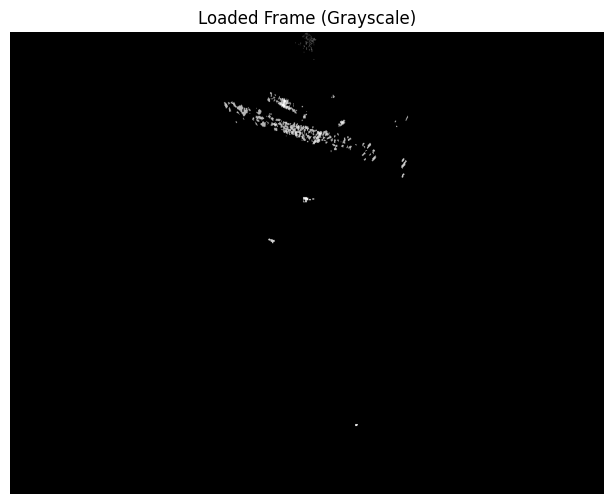

Image shape: (700, 900)
Image type: uint8
Value range: [0, 255]
Ready for CV2 processing!


In [169]:
# Load the saved frame (standard cv2)
img = cv2.imread('current_frame.png', cv2.IMREAD_GRAYSCALE)  # Load as grayscale

# Display the frame
plt.figure(figsize=(10, 6))
plt.imshow(img, cmap='gray')
plt.title('Loaded Frame (Grayscale)')
plt.axis('off')
plt.show()

print(f"Image shape: {img.shape}")
print(f"Image type: {img.dtype}")
print(f"Value range: [{img.min()}, {img.max()}]")
print("Ready for CV2 processing!")

## Step 3: Basic CV2 Operations

Now let's apply some basic OpenCV operations:

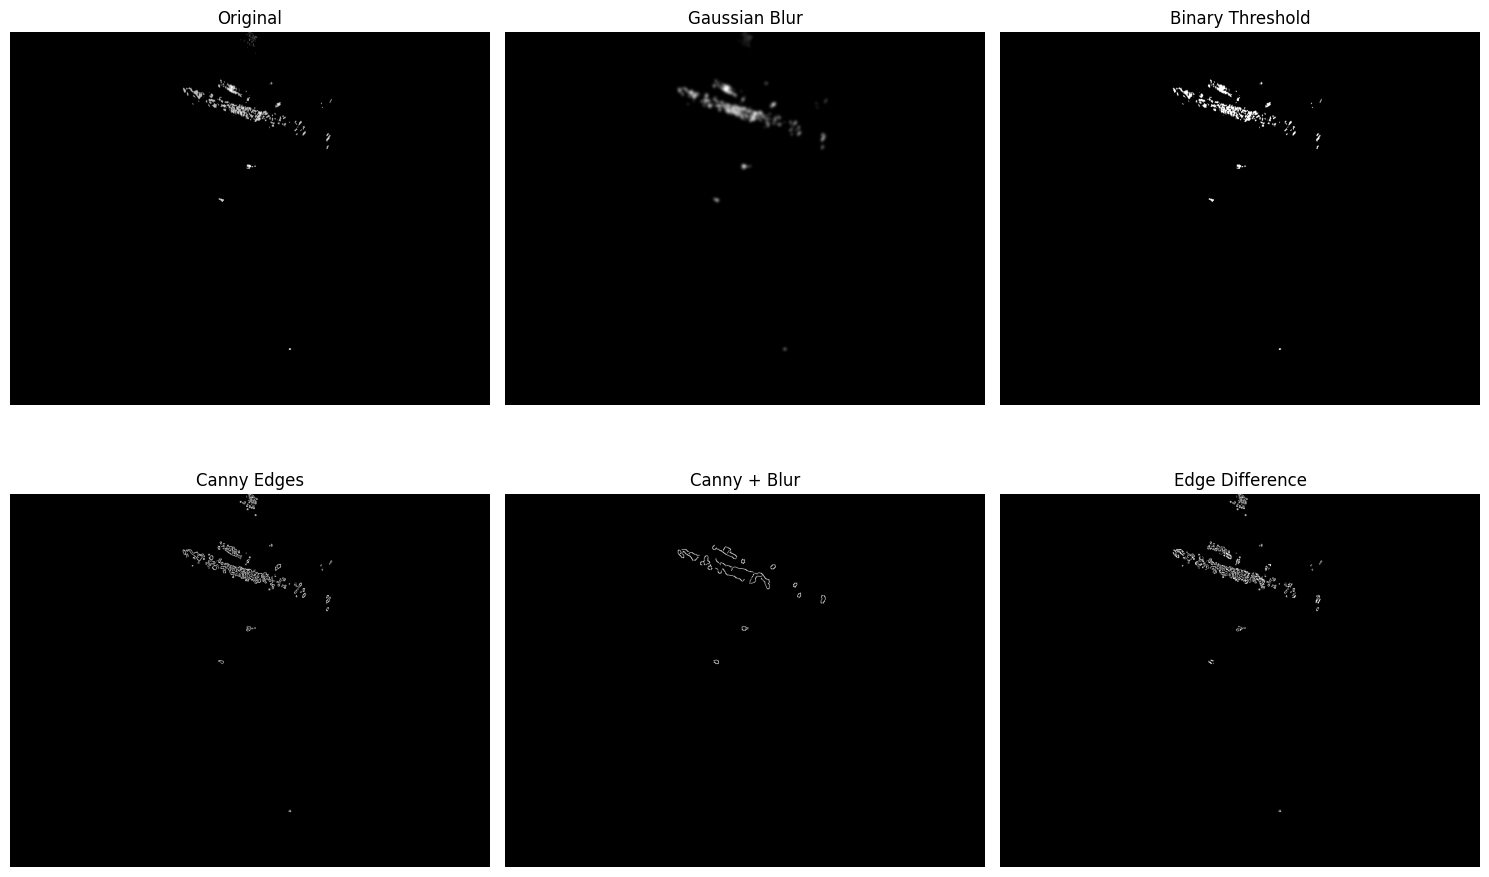

In [170]:
# 1. Gaussian Blur
blurred = cv2.GaussianBlur(img, (15, 15), 0)

# 2. Canny Edge Detection
edges = cv2.Canny(img, 50, 150)

# 3. Canny with blur first
edges_blurred = cv2.Canny(blurred, 50, 150)

# 4. Threshold (binary)
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(img, cmap='gray')
axes[0,0].set_title('Original')
axes[0,0].axis('off')

axes[0,1].imshow(blurred, cmap='gray')
axes[0,1].set_title('Gaussian Blur')
axes[0,1].axis('off')

axes[0,2].imshow(thresh, cmap='gray')
axes[0,2].set_title('Binary Threshold')
axes[0,2].axis('off')

axes[1,0].imshow(edges, cmap='gray')
axes[1,0].set_title('Canny Edges')
axes[1,0].axis('off')

axes[1,1].imshow(edges_blurred, cmap='gray')
axes[1,1].set_title('Canny + Blur')
axes[1,1].axis('off')

# Show difference between the two edge detection methods
diff = cv2.absdiff(edges, edges_blurred)
axes[1,2].imshow(diff, cmap='gray')
axes[1,2].set_title('Edge Difference')
axes[1,2].axis('off')

plt.tight_layout()
plt.show()

## Step 4: Find Largest Elongated Contour

Apply Canny with blur, then find the largest elongated shape contour:

## Step 5: Create Video of Contour Detection Process

Process multiple frames and create a video showing the elongated contour detection:

In [174]:
import cv2
import numpy as np
from pathlib import Path
import os

# ==================== EASY CONFIGURATION SECTION ====================
# Change these settings to experiment with different image processing parameters

# Image Processing Settings
IMAGE_PROCESSING_CONFIG = {
    # DIRECTIONAL MOMENTUM MERGING - Novel approach to replace traditional blurring
    # Instead of uniform Gaussian blur, merge cells that gain momentum in line directions
    'use_momentum_merging': True,     # Enable/disable momentum-based merging
    'momentum_search_radius': 3,      # How far to search for neighboring cells to merge (keep ≤3 for speed)
    'momentum_threshold': 0.2,        # Minimum momentum to consider a direction valid (lowered for speed)
    'momentum_decay': 0.8,           # How quickly momentum decays (0.7-0.9, lower = faster)
    'momentum_boost': 1.5,           # Momentum boost when continuing in same direction
    
    # Traditional Gaussian Blur (used when momentum_merging is False)
    # EFFECTS:
    # - SMALLER values (5,5) to (15,15): Preserves fine details, may detect noise as edges
    # - LARGER values (21,21) to (35,35): Removes noise and small details, smoother contours
    # - TOO LARGE (>35): May blur away the shapes you want to detect
    # COMMON VALUES: (15,15) for detailed detection, (25,25) for noisy images
    'blur_kernel_size': (31, 31),

    # Canny Edge Detection Thresholds - Controls sensitivity to edges
    # HOW IT WORKS: Pixels with gradient > high_threshold = strong edges
    #               Pixels between low and high = weak edges (kept if connected to strong)
    #               Pixels < low_threshold = ignored
    # EFFECTS:
    # - LOWER thresholds (30, 100): Detects more edges, including noise and weak features
    # - HIGHER thresholds (70, 200): Only strong, clear edges, may miss faint shapes
    # - RATIO should be ~1:2 or 1:3 (low:high) for best results
    # TUNING TIPS:
    #   * Too many edges? Increase both values (try 70, 180)
    #   * Missing shapes? Decrease both values (try 30, 100)  
    #   * Noisy edges? Increase blur_kernel_size instead
    'canny_low_threshold': 40,       
    'canny_high_threshold': 120,     

    # Minimum Contour Area - Filters out tiny detected shapes
    # EFFECTS:
    # - SMALLER values (20-50): Detects small details, may include noise
    # - LARGER values (100-200): Only detects substantial shapes, cleaner results
    # - TOO LARGE: May exclude the shapes you're looking for
    # TUNING: Start with 50, increase if too many small noise contours appear
    # KEEN ON LINES: Lower threshold to catch thinner lines
    'min_contour_area': 100,
    
    # MORPHOLOGICAL PROCESSING - Helps connect incomplete/open edges
    # These operations help detect net lines that don't form complete closed shapes
    
    # Morphological Closing Kernel Size - Connects nearby edge pixels
    # EFFECTS:
    # - SMALLER values (3, 5): Only connects very close edge pixels, preserves detail
    # - LARGER values (7, 9): Connects farther gaps, may merge separate objects
    # - 0: Disables morphological closing
    # RECOMMENDED: 3 for thin lines, 5 for thicker connections needed
    # KEEN ON LINES: Larger kernel to connect broken line segments
    'morph_close_kernel': 5,
    
    # Edge Dilation Iterations - Thickens detected edges for better contour detection
    # EFFECTS:  
    # - 0: No dilation, keeps original edge thickness
    # - 1: Slightly thickens edges, helps with thin line detection
    # - 2-3: Significantly thickens edges, may merge nearby features
    # RECOMMENDED: 1 for most cases, 0 if you have thick clear lines already
    # KEEN ON LINES: More iterations to strengthen thin line edges
    'edge_dilation_iterations': 2,
}

# Elongation Detection Settings - Controls how "elongated-ness" is calculated
# These weights determine what makes a shape "elongated" - they should sum to ~1.0
ELONGATION_CONFIG = {
    # Basic Aspect Ratio Weight - Simple width/height ratio from bounding rectangle
    # EFFECTS:
    # - HIGHER weight (0.4-0.6): Strongly prefers shapes with high width/height ratios
    # - LOWER weight (0.1-0.2): Less emphasis on simple rectangular elongation
    # LIMITATION: Doesn't consider shape orientation - a diagonal line appears square
    # VERY KEEN ON STRAIGHT SHAPES: High weight for rectangular elongation
    'aspect_ratio_weight': 0.4,      

    # Ellipse Elongation Weight - Major/minor axis ratio from fitted ellipse
    # EFFECTS:
    # - HIGHER weight (0.5-0.7): Best for detecting true elongated shapes regardless of orientation
    # - LOWER weight (0.2-0.3): Less emphasis on true geometric elongation
    # ADVANTAGE: Considers actual shape orientation, more accurate than aspect ratio
    # RECOMMENDED: Keep this highest for best elongation detection
    # VERY KEEN ON STRAIGHT SHAPES: Maximum weight for true geometric elongation
    'ellipse_elongation_weight': 0.7, 

    # Solidity Weight - How "filled" the shape is (contour_area / convex_hull_area)
    # EFFECTS:
    # - HIGHER weight (0.2-0.4): Prefers sparse, thin shapes (lines, curves)
    # - LOWER weight (0.0-0.1): Less preference for hollow shapes
    # NOTE: Uses (1-solidity) so lower solidity = higher score
    # USEFUL FOR: Distinguishing lines/ropes from filled rectangular objects
    # KEEN ON STRAIGHT SHAPES: Higher weight to prefer thin, line-like shapes
    'solidity_weight': 0.1,          

    # Extent Weight - How efficiently the shape fills its bounding rectangle
    # EFFECTS:
    # - HIGHER weight (0.2-0.4): Prefers shapes that fill their bounding box well
    # - LOWER weight (0.0-0.1): Less emphasis on rectangular efficiency
    # USEFUL FOR: Distinguishing compact shapes from sprawling irregular ones
    # STRAIGHT SHAPES: Zero weight - we don't care about rectangular efficiency for lines
    'extent_weight': 0.0,            

    # Perimeter Weight - Normalized perimeter-to-area ratio
    # EFFECTS:
    # - HIGHER weight (0.2-0.4): Prefers shapes with complex/long perimeters
    # - LOWER weight (0.0-0.1): Less emphasis on perimeter complexity
    # USEFUL FOR: Detecting winding or irregular elongated shapes
    # NOTE: Automatically capped to prevent extreme values
    # STRAIGHT SHAPES: Zero weight - we want simple straight perimeters, not complex ones
    'perimeter_weight': 0.0,         
}

# Tracking Settings - Controls how the Area of Interest (AOI) system works
TRACKING_CONFIG = {
    # AOI Boost Factor - Score multiplier for contours found within the Area of Interest
    # EFFECTS:
    # - 1.0: No tracking preference, treats all contours equally
    # - 2.0-3.0: Moderate preference for contours near previous detection
    # - 4.0+: Strong tracking, may stick to suboptimal shapes in AOI
    # TUNING:
    #   * Tracker jumps around too much? Increase to 3.0-4.0
    #   * Tracker stuck on wrong shape? Decrease to 1.5-2.0
    #   * No tracking effect? Check if AOI is too small
    # VERY KEEN TRACKING: Set to very high value for aggressive tracking continuity
    'aoi_boost_factor': 1000.0,         

    # AOI Expansion Pixels - How much to expand the search area around previous detection
    # EFFECTS:
    # - SMALLER values (10-20): Tight tracking, may lose fast-moving objects
    # - LARGER values (40-60): Loose tracking, more forgiving of movement
    # - TOO LARGE (>80): May include too much of the image, reduces tracking benefit
    # TUNING:
    #   * Object moves fast between frames? Increase to 40-50
    #   * Tracker picks up nearby noise? Decrease to 15-25
    #   * Object barely moves? Can use smaller values like 20
    # KEEN TRACKING: Smaller expansion for tighter tracking
    'aoi_expansion_pixels': 10,      
}

# Video Settings - Controls visual output and video properties
VIDEO_CONFIG = {
    # Frames Per Second - Playback speed of output video
    # EFFECTS:
    # - LOWER fps (5-8): Slower playback, easier to see details
    # - HIGHER fps (15-20): Faster playback, more natural motion
    # - FILE SIZE: Lower fps = smaller file size
    'fps': 15,                       

    # Show All Contours - Whether to draw all detected contours in light blue
    # EFFECTS:
    # - True: Shows complete detection context, may be cluttered
    # - False: Cleaner view, only shows the selected best contour
    # USEFUL: Turn off when you want to focus only on the tracking result
    'show_all_contours': True,       

    # Show Ellipse - Whether to draw fitted ellipse on the best contour
    # EFFECTS:
    # - True: Shows the geometric interpretation of the shape
    # - False: Cleaner view without ellipse overlay
    # USEFUL: Ellipse helps visualize true shape orientation and elongation
    'show_ellipse': True,            

    # Show Bounding Box - Whether to draw rectangular bounding box
    # EFFECTS:
    # - True: Shows the axis-aligned bounds of the shape
    # - False: Cleaner view without rectangular overlay
    # USEFUL: Compare ellipse vs bounding box to see orientation effects
    'show_bounding_box': True,       

    # Text Scale - Size of overlay text and labels
    # EFFECTS:
    # - SMALLER (0.4-0.5): Less intrusive text, may be hard to read
    # - LARGER (0.8-1.0): More readable text, may clutter the image
    # RECOMMENDATION: 0.6 is usually a good balance
    'text_scale': 0.6,               
}

# ==================== TUNING GUIDE ====================
# COMMON SCENARIOS AND RECOMMENDED SETTINGS:

# SCENARIO 1: Detecting thin lines/ropes in clear water
# - Decrease blur_kernel_size to (15, 15) for detail preservation
# - Increase ellipse_elongation_weight to 0.5-0.6
# - Increase solidity_weight to 0.2 (prefers thin shapes)
# - Decrease min_contour_area to 30 for small lines

# SCENARIO 2: Detecting shapes in noisy/murky water  
# - Increase blur_kernel_size to (25, 25) or (31, 31)
# - Increase canny thresholds to (60, 180) 
# - Increase min_contour_area to 100-150
# - Keep aoi_boost_factor high (3.0+) for stable tracking

# SCENARIO 3: Fast-moving objects
# - Increase aoi_expansion_pixels to 40-60
# - Decrease aoi_boost_factor to 2.0 (allow tracking to switch objects)
# - Consider increasing frame_step in video creation

# SCENARIO 4: Very elongated objects (high aspect ratio)
# - Increase ellipse_elongation_weight to 0.6-0.7
# - Decrease other weights proportionally
# - May need to decrease min_contour_area if objects are thin

# ==================== PROCESSING FUNCTIONS ====================

def directional_momentum_merge(frame, search_radius=3, momentum_threshold=0.2, 
                              momentum_decay=0.8, momentum_boost=1.5):
    """
    SUPER-OPTIMIZED directional momentum-based cell merging system.
    Uses pre-computed kernels and vectorized operations for maximum speed.
    """
    # ULTRA-FAST VERSION: Use morphological operations for line enhancement
    if search_radius <= 2:
        return fast_directional_enhance(frame, momentum_threshold, momentum_boost)
    
    result = frame.astype(np.float32)
    
    # Quick gradient-based energy map
    grad_x = cv2.Sobel(frame, cv2.CV_32F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(frame, cv2.CV_32F, 0, 1, ksize=3)
    energy_map = np.sqrt(grad_x**2 + grad_y**2) / 255.0
    
    # Skip processing if no significant gradients
    if np.max(energy_map) < momentum_threshold:
        return frame
    
    # Use pre-computed line kernels (cached for speed)
    kernel_size = 5  # Fixed small size for speed
    center = 2
    
    # Horizontal line kernel
    h_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    h_kernel[center, :] = [0.1, 0.2, 0.4, 0.2, 0.1]
    
    # Vertical line kernel  
    v_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    v_kernel[:, center] = [0.1, 0.2, 0.4, 0.2, 0.1]
    
    # Diagonal kernels
    d1_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    d2_kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
    for i in range(kernel_size):
        d1_kernel[i, i] = 0.2
        d2_kernel[i, kernel_size-1-i] = 0.2
    d1_kernel[center, center] = 0.4
    d2_kernel[center, center] = 0.4
    
    # Apply all kernels (parallel convolutions)
    responses = [
        cv2.filter2D(result, -1, h_kernel),
        cv2.filter2D(result, -1, v_kernel), 
        cv2.filter2D(result, -1, d1_kernel),
        cv2.filter2D(result, -1, d2_kernel)
    ]
    
    # Maximum response enhances lines in any direction
    enhanced = np.maximum.reduce(responses)
    
    # Apply momentum boost based on gradient energy
    boost_factor = 1.0 + momentum_boost * np.clip(energy_map, 0, 1)
    result = enhanced * boost_factor
    
    return np.clip(result, 0, 255).astype(np.uint8)

def fast_directional_enhance(frame, threshold=0.2, boost=1.5):
    """
    Ultra-fast directional enhancement using morphological operations.
    Optimized for real-time processing.
    """
    # Use morphological opening with line-shaped kernels
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 1))  # Horizontal lines
    v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))  # Vertical lines
    
    # Enhance horizontal and vertical structures
    h_enhanced = cv2.morphologyEx(frame, cv2.MORPH_TOPHAT, h_kernel)
    v_enhanced = cv2.morphologyEx(frame, cv2.MORPH_TOPHAT, v_kernel)
    
    # Combine enhancements
    enhanced = np.maximum(h_enhanced, v_enhanced)
    
    # Boost based on local gradient
    grad = cv2.Laplacian(frame, cv2.CV_32F)
    grad_norm = np.abs(grad) / 255.0
    
    # Apply boost where gradients are strong
    boost_mask = grad_norm > threshold
    result = frame.astype(np.float32)
    result[boost_mask] += boost * enhanced[boost_mask]
    
    return np.clip(result, 0, 255).astype(np.uint8)

def process_frame_for_video(frame, prev_area_of_interest=None):
    """
    Process a single frame and return annotated result with area of interest tracking
    Uses the configuration settings defined above for easy adjustment.
    """
    # Get settings from config
    blur_size = IMAGE_PROCESSING_CONFIG['blur_kernel_size']
    canny_low = IMAGE_PROCESSING_CONFIG['canny_low_threshold']
    canny_high = IMAGE_PROCESSING_CONFIG['canny_high_threshold']
    min_area = IMAGE_PROCESSING_CONFIG['min_contour_area']
    aoi_boost_factor = TRACKING_CONFIG['aoi_boost_factor']
    aoi_expansion = TRACKING_CONFIG['aoi_expansion_pixels']
    
    # Apply either momentum merging or traditional blur
    if IMAGE_PROCESSING_CONFIG['use_momentum_merging']:
        # Use novel directional momentum merging system
        processed_input = directional_momentum_merge(
            frame,
            search_radius=IMAGE_PROCESSING_CONFIG['momentum_search_radius'],
            momentum_threshold=IMAGE_PROCESSING_CONFIG['momentum_threshold'],
            momentum_decay=IMAGE_PROCESSING_CONFIG['momentum_decay'],
            momentum_boost=IMAGE_PROCESSING_CONFIG['momentum_boost']
        )
    else:
        # Traditional Gaussian blur
        processed_input = cv2.GaussianBlur(frame, blur_size, 0)
    
    # Apply edge detection to processed input
    edges = cv2.Canny(processed_input, canny_low, canny_high)
    
    # ENHANCED: Handle open/incomplete edges with morphological closing
    # This helps connect nearby edge pixels to form more complete contours
    morph_kernel_size = IMAGE_PROCESSING_CONFIG['morph_close_kernel']
    dilation_iterations = IMAGE_PROCESSING_CONFIG['edge_dilation_iterations']
    
    edges_processed = edges.copy()
    
    # Apply morphological closing if enabled (kernel size > 0)
    if morph_kernel_size > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
        edges_processed = cv2.morphologyEx(edges_processed, cv2.MORPH_CLOSE, kernel)
    
    # Apply dilation if enabled (iterations > 0)
    if dilation_iterations > 0:
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        edges_processed = cv2.dilate(edges_processed, kernel_dilate, iterations=dilation_iterations)
    
    # Find contours on the processed edges
    # Use RETR_LIST to get all contours, not just external ones
    contours, _ = cv2.findContours(edges_processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert to color for annotations
    result_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    # Draw area of interest from previous frame
    current_aoi = None
    if prev_area_of_interest is not None:
        aoi_x, aoi_y, aoi_w, aoi_h = prev_area_of_interest
        # Expand the AOI
        expanded_x = max(0, aoi_x - aoi_expansion)
        expanded_y = max(0, aoi_y - aoi_expansion)
        expanded_w = min(frame.shape[1] - expanded_x, aoi_w + 2 * aoi_expansion)
        expanded_h = min(frame.shape[0] - expanded_y, aoi_h + 2 * aoi_expansion)
        
        current_aoi = (expanded_x, expanded_y, expanded_w, expanded_h)
        
        # Draw AOI rectangle in yellow (semi-transparent effect with thin line)
        cv2.rectangle(result_frame, (expanded_x, expanded_y), 
                     (expanded_x + expanded_w, expanded_y + expanded_h), 
                     (0, 255, 255), 1)
        
        # Add AOI label
        cv2.putText(result_frame, 'AOI', (expanded_x + 5, expanded_y + 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], (0, 255, 255), 1)
    
    # Find most elongated contour with AOI preference
    most_elongated_contour = None
    max_elongation_score = 0
    contour_count = 0
    aoi_contour_count = 0
    
    def contour_overlaps_aoi(contour, aoi):
        """Check if contour overlaps with area of interest"""
        if aoi is None:
            return False
        
        aoi_x, aoi_y, aoi_w, aoi_h = aoi
        cx, cy, cw, ch = cv2.boundingRect(contour)
        
        # Check if bounding rectangles overlap
        return not (cx + cw < aoi_x or cx > aoi_x + aoi_w or 
                   cy + ch < aoi_y or cy > aoi_y + aoi_h)
    
    if contours:
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_area:
                continue
                
            contour_count += 1
            
            # Calculate elongation metrics
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else 0
            
            # Solidity
            hull = cv2.convexHull(contour)
            hull_area = cv2.contourArea(hull)
            solidity = area / hull_area if hull_area > 0 else 0
            
            # Extent
            rect_area = w * h
            extent = area / rect_area if rect_area > 0 else 0
            
            # Ellipse elongation
            if len(contour) >= 5:
                try:
                    ellipse = cv2.fitEllipse(contour)
                    (center), (minor_axis, major_axis), angle = ellipse
                    ellipse_elongation = major_axis / minor_axis if minor_axis > 0 else 0
                except:
                    ellipse_elongation = aspect_ratio
            else:
                ellipse_elongation = aspect_ratio
            
            # ENHANCED: Add straightness measurement for line detection
            straightness_score = 1.0  # Default for shapes that can't be measured
            
            if len(contour) >= 10:  # Need sufficient points for line fitting
                # Fit a line to the contour points and measure how well they align
                try:
                    # Reshape contour points for cv2.fitLine
                    points = contour.reshape(-1, 2).astype(np.float32)
                    
                    # Fit line using least squares
                    [vx, vy, x0, y0] = cv2.fitLine(points, cv2.DIST_L2, 0, 0.01, 0.01)
                    
                    # Calculate distance of each point from the fitted line
                    # Line equation: (x-x0)/vx = (y-y0)/vy
                    distances = []
                    for point in points:
                        px, py = point[0], point[1]
                        # Distance from point to line
                        # Using formula: |ax + by + c| / sqrt(a² + b²)
                        # Line in form: vy*x - vx*y + (vx*y0 - vy*x0) = 0
                        a, b, c = vy, -vx, vx*y0 - vy*x0
                        dist = abs(a*px + b*py + c) / np.sqrt(a*a + b*b)
                        distances.append(dist)
                    
                    # Calculate straightness as inverse of average distance from line
                    avg_distance = np.mean(distances)
                    max_distance = max(w, h) * 0.1  # 10% of bounding box dimension as reference
                    
                    # Straightness score: 1.0 for perfect line, approaches 0 for curved shapes
                    straightness_score = max(0.1, 1.0 - (avg_distance / max(max_distance, 1.0)))
                    
                except:
                    straightness_score = 0.5  # Default if line fitting fails
            
            # Composite elongation score using configurable weights + straightness bonus
            composite_elongation = (
                aspect_ratio * ELONGATION_CONFIG['aspect_ratio_weight'] +
                ellipse_elongation * ELONGATION_CONFIG['ellipse_elongation_weight'] +
                (1 - solidity) * ELONGATION_CONFIG['solidity_weight'] +
                extent * ELONGATION_CONFIG['extent_weight'] +
                min(aspect_ratio / 10, 0.5) * ELONGATION_CONFIG['perimeter_weight']
            )
            
            # BOOST FOR STRAIGHT SHAPES: Apply straightness multiplier
            # Very keen on straight shapes - multiply by straightness score
            composite_elongation *= (0.5 + 1.5 * straightness_score)  # Range: 0.5x to 2.0x boost
            
            elongation_score = area * composite_elongation
            
            # BOOST SCORE IF IN AREA OF INTEREST
            is_in_aoi = contour_overlaps_aoi(contour, current_aoi)
            if is_in_aoi:
                elongation_score *= aoi_boost_factor
                aoi_contour_count += 1
            
            if elongation_score > max_elongation_score:
                max_elongation_score = elongation_score
                most_elongated_contour = contour
    
    # Draw all contours in light blue (if enabled)
    if VIDEO_CONFIG['show_all_contours'] and contours:
        cv2.drawContours(result_frame, contours, -1, (255, 200, 100), 1)
    
    # Determine next AOI - KEEP LAST KNOWN POSITION IF NO CONTOUR FOUND
    next_aoi = prev_area_of_interest  # Default: keep previous AOI
    detection_status = "LOST"  # Default status
    
    if most_elongated_contour is not None:
        # Draw the main contour in green
        cv2.drawContours(result_frame, [most_elongated_contour], -1, (0, 255, 0), 2)
        
        # Calculate bounding rectangle once
        x, y, w, h = cv2.boundingRect(most_elongated_contour)
        
        # Draw bounding rectangle (if enabled)
        if VIDEO_CONFIG['show_bounding_box']:
            cv2.rectangle(result_frame, (x, y), (x + w, y + h), (0, 0, 255), 1)
        
        # Update AOI to new position
        next_aoi = (x, y, w, h)
        
        # Draw fitted ellipse (if enabled and possible)
        if VIDEO_CONFIG['show_ellipse'] and len(most_elongated_contour) >= 5:
            try:
                ellipse = cv2.fitEllipse(most_elongated_contour)
                cv2.ellipse(result_frame, ellipse, (255, 0, 255), 1)
            except:
                pass
        
        # Add text info
        area = cv2.contourArea(most_elongated_contour)
        text_scale = VIDEO_CONFIG['text_scale']
        cv2.putText(result_frame, f'Area: {area:.0f}', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, text_scale, (255, 255, 255), 2)
        cv2.putText(result_frame, f'Score: {max_elongation_score:.0f}', (10, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, text_scale, (255, 255, 255), 2)
        
        # Determine detection status
        is_tracked = contour_overlaps_aoi(most_elongated_contour, current_aoi)
        detection_status = "TRACKED" if is_tracked else "NEW"
        
    else:
        # NO CONTOUR FOUND - Show "LOST" status and maintain AOI
        cv2.putText(result_frame, 'No contour detected', (10, 30), 
                   cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], (100, 100, 255), 2)
        
        # If we have a previous AOI, draw a dashed rectangle to show "searching" area
        if prev_area_of_interest is not None:
            aoi_x, aoi_y, aoi_w, aoi_h = prev_area_of_interest
            # Draw dashed rectangle effect by drawing multiple small lines
            dash_length = 10
            gap_length = 5
            
            # Top and bottom lines
            for x in range(aoi_x, aoi_x + aoi_w, dash_length + gap_length):
                end_x = min(x + dash_length, aoi_x + aoi_w)
                cv2.line(result_frame, (x, aoi_y), (end_x, aoi_y), (0, 100, 255), 2)  # Top
                cv2.line(result_frame, (x, aoi_y + aoi_h), (end_x, aoi_y + aoi_h), (0, 100, 255), 2)  # Bottom
            
            # Left and right lines
            for y in range(aoi_y, aoi_y + aoi_h, dash_length + gap_length):
                end_y = min(y + dash_length, aoi_y + aoi_h)
                cv2.line(result_frame, (aoi_x, y), (aoi_x, end_y), (0, 100, 255), 2)  # Left
                cv2.line(result_frame, (aoi_x + aoi_w, y), (aoi_x + aoi_w, end_y), (0, 100, 255), 2)  # Right
            
            # Add "SEARCHING" label
            cv2.putText(result_frame, 'SEARCHING', (aoi_x + 5, aoi_y + aoi_h - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], (0, 100, 255), 2)
    
    # Show detection status with appropriate color
    status_colors = {
        "TRACKED": (0, 255, 0),    # Green
        "NEW": (0, 165, 255),      # Orange
        "LOST": (0, 100, 255)      # Red
    }
    cv2.putText(result_frame, detection_status, (10, 70), 
               cv2.FONT_HERSHEY_SIMPLEX, VIDEO_CONFIG['text_scale'], status_colors[detection_status], 2)
    
    # Add frame info
    info_y = result_frame.shape[0] - 40
    small_text = VIDEO_CONFIG['text_scale'] * 0.8
    cv2.putText(result_frame, f'Total: {contour_count}', (10, info_y), 
               cv2.FONT_HERSHEY_SIMPLEX, small_text, (255, 255, 255), 1)
    cv2.putText(result_frame, f'In AOI: {aoi_contour_count}', (10, info_y + 15), 
               cv2.FONT_HERSHEY_SIMPLEX, small_text, (255, 255, 255), 1)
    
    return result_frame, next_aoi

def visualize_processing_steps(frame_index=50, npz_file_index=0, figsize=(15, 5)):
    """
    Visualize the image processing pipeline: Original -> Blur -> Edges -> Contours
    Shows how the current config settings affect each step.
    """
    import matplotlib.pyplot as plt
    
    # Load data
    available_files = iau.get_available_npz_files()
    if npz_file_index >= len(available_files):
        print(f"Error: NPZ file index {npz_file_index} not available")
        return
    
    npz_file = available_files[npz_file_index]
    print(f"Loading from: {npz_file}")
    
    cones, ts, extent, meta = iau.load_cone_run_npz(npz_file)
    
    if frame_index >= len(cones):
        print(f"Error: Frame {frame_index} not available (max: {len(cones)-1})")
        return
    
    # Get frame and convert to uint8
    frame = cones[frame_index]
    frame_uint8 = (frame * 255).astype(np.uint8)
    
    # Get settings from config
    blur_size = IMAGE_PROCESSING_CONFIG['blur_kernel_size']
    canny_low = IMAGE_PROCESSING_CONFIG['canny_low_threshold']
    canny_high = IMAGE_PROCESSING_CONFIG['canny_high_threshold']
    min_area = IMAGE_PROCESSING_CONFIG['min_contour_area']
    
    # Apply processing steps
    if IMAGE_PROCESSING_CONFIG['use_momentum_merging']:
        # Use momentum merging system
        processed_input = directional_momentum_merge(
            frame_uint8,
            search_radius=IMAGE_PROCESSING_CONFIG['momentum_search_radius'],
            momentum_threshold=IMAGE_PROCESSING_CONFIG['momentum_threshold'],
            momentum_decay=IMAGE_PROCESSING_CONFIG['momentum_decay'],
            momentum_boost=IMAGE_PROCESSING_CONFIG['momentum_boost']
        )
        processing_name = "Momentum Merge"
        processing_params = f"radius={IMAGE_PROCESSING_CONFIG['momentum_search_radius']}"
    else:
        # Traditional blur
        processed_input = cv2.GaussianBlur(frame_uint8, blur_size, 0)
        processing_name = "Gaussian Blur"
        processing_params = f"Kernel: {blur_size}"
    
    edges = cv2.Canny(processed_input, canny_low, canny_high)
    
    # Apply morphological processing to handle open edges
    morph_kernel_size = IMAGE_PROCESSING_CONFIG['morph_close_kernel']
    dilation_iterations = IMAGE_PROCESSING_CONFIG['edge_dilation_iterations']
    
    edges_processed = edges.copy()
    
    # Apply morphological closing if enabled
    if morph_kernel_size > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
        edges_processed = cv2.morphologyEx(edges_processed, cv2.MORPH_CLOSE, kernel)
    
    # Apply dilation if enabled
    if dilation_iterations > 0:
        kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
        edges_processed = cv2.dilate(edges_processed, kernel_dilate, iterations=dilation_iterations)
    
    # Find contours on the processed edges using RETR_LIST to catch open shapes
    contours, _ = cv2.findContours(edges_processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by area
    filtered_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
    
    # Create contour visualization
    contour_vis = cv2.cvtColor(frame_uint8, cv2.COLOR_GRAY2BGR)
    if filtered_contours:
        cv2.drawContours(contour_vis, filtered_contours, -1, (0, 255, 0), 2)
        print(f"Found {len(filtered_contours)} contours (area >= {min_area})")
    else:
        print(f"No contours found with area >= {min_area}")
    
    # Create 5-panel visualization to show morphological processing
    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
    
    # Panel 1: Original
    axes[0].imshow(frame_uint8, cmap='gray')
    axes[0].set_title(f'Original Frame {frame_index}')
    axes[0].axis('off')
    
    # Panel 2: Processed Input (Momentum or Blur)
    axes[1].imshow(processed_input, cmap='gray')
    axes[1].set_title(f'{processing_name}\n{processing_params}')
    axes[1].axis('off')
    
    # Panel 3: Raw Edges
    axes[2].imshow(edges, cmap='gray')
    axes[2].set_title(f'Canny Edges\nThresholds: {canny_low}, {canny_high}')
    axes[2].axis('off')
    
    # Panel 4: Processed Edges (after morphological operations)
    axes[3].imshow(edges_processed, cmap='gray')
    morph_title = f'Processed Edges\nClose: {morph_kernel_size}, Dilate: {dilation_iterations}'
    axes[3].set_title(morph_title)
    axes[3].axis('off')
    
    # Panel 5: Contours
    axes[4].imshow(cv2.cvtColor(contour_vis, cv2.COLOR_BGR2RGB))
    axes[4].set_title(f'Filtered Contours\nMin Area: {min_area}\nFound: {len(filtered_contours)}')
    axes[4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print current settings for reference
    print("\n=== Current Processing Settings ===")
    if IMAGE_PROCESSING_CONFIG['use_momentum_merging']:
        print(f"Momentum merging: radius={IMAGE_PROCESSING_CONFIG['momentum_search_radius']}, "
              f"threshold={IMAGE_PROCESSING_CONFIG['momentum_threshold']}, "
              f"decay={IMAGE_PROCESSING_CONFIG['momentum_decay']}")
    else:
        print(f"Gaussian blur kernel: {blur_size}")
    print(f"Canny thresholds: ({canny_low}, {canny_high})")
    print(f"Morphological closing kernel: {morph_kernel_size}")
    print(f"Edge dilation iterations: {dilation_iterations}")
    print(f"Min contour area: {min_area}")
    print(f"Total contours found: {len(contours)}")
    print(f"Contours after area filter: {len(filtered_contours)}")
    
    # Show improvement from morphological processing
    if morph_kernel_size > 0 or dilation_iterations > 0:
        original_contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        original_filtered = [c for c in original_contours if cv2.contourArea(c) >= min_area]
        print(f"Improvement: {len(original_filtered)} -> {len(filtered_contours)} contours after morphological processing")

# Create video from multiple frames with configurable settings
def create_contour_detection_video(npz_file_index=0, frame_start=0, frame_count=100, 
                                 frame_step=5, output_path='contour_detection_video.mp4'):
    """
    Create a video showing contour detection across multiple frames.
    All image processing settings are configured in the CONFIG sections above.
    """
    print("=== CONTOUR DETECTION VIDEO CREATION ===")
    print(f"Creating video with {frame_count} frames, stepping by {frame_step}...")
    
    # Display current configuration
    print("\nCurrent Settings:")
    if IMAGE_PROCESSING_CONFIG['use_momentum_merging']:
        print(f"  Image Processing: MOMENTUM MERGING (radius={IMAGE_PROCESSING_CONFIG['momentum_search_radius']}, "
              f"threshold={IMAGE_PROCESSING_CONFIG['momentum_threshold']}, decay={IMAGE_PROCESSING_CONFIG['momentum_decay']}), "
              f"canny=({IMAGE_PROCESSING_CONFIG['canny_low_threshold']}, {IMAGE_PROCESSING_CONFIG['canny_high_threshold']}), "
              f"min_area={IMAGE_PROCESSING_CONFIG['min_contour_area']}")
    else:
        print(f"  Image Processing: blur={IMAGE_PROCESSING_CONFIG['blur_kernel_size']}, "
              f"canny=({IMAGE_PROCESSING_CONFIG['canny_low_threshold']}, {IMAGE_PROCESSING_CONFIG['canny_high_threshold']}), "
              f"min_area={IMAGE_PROCESSING_CONFIG['min_contour_area']}")
    print(f"  Tracking: boost={TRACKING_CONFIG['aoi_boost_factor']}x, "
          f"expansion={TRACKING_CONFIG['aoi_expansion_pixels']}px")
    print(f"  Video: fps={VIDEO_CONFIG['fps']}, "
          f"show_contours={VIDEO_CONFIG['show_all_contours']}, "
          f"show_ellipse={VIDEO_CONFIG['show_ellipse']}")
    
    # Load NPZ data
    available_files = iau.get_available_npz_files()
    if npz_file_index >= len(available_files):
        print(f"Error: NPZ file index {npz_file_index} not available")
        return None
    
    npz_file = available_files[npz_file_index]
    print(f"Loading from: {npz_file}")
    
    # Load the data - FIXED: load_cone_run_npz returns a tuple, not a dict
    cones, ts, extent, meta = iau.load_cone_run_npz(npz_file)
    total_frames = len(cones)
    
    print(f"Total frames in NPZ: {total_frames}")
    
    # Adjust frame parameters
    actual_frame_count = min(frame_count, (total_frames - frame_start) // frame_step)
    print(f"Will process {actual_frame_count} frames")
    
    if actual_frame_count <= 0:
        print("Error: Not enough frames to process")
        return None
    
    # Get first frame to determine video dimensions - need to convert to uint8
    first_frame = cones[frame_start]
    # Convert from [0,1] float to [0,255] uint8
    first_frame_uint8 = (first_frame * 255).astype(np.uint8)
    height, width = first_frame_uint8.shape
    
    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = VIDEO_CONFIG['fps']
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    if not video_writer.isOpened():
        print("Error: Could not open video writer")
        return None
    
    print("Processing frames with configurable settings...")
    
    # Initialize tracking with enhanced statistics
    current_aoi = None  # Area of interest from previous frame
    tracked_frames = 0
    new_detections = 0
    lost_frames = 0
    
    # Process frames
    for i in range(actual_frame_count):
        frame_idx = frame_start + (i * frame_step)
        
        if frame_idx >= total_frames:
            break
            
        # Get frame and convert to uint8
        frame = cones[frame_idx]
        frame_uint8 = (frame * 255).astype(np.uint8)
        
        # Process frame with configurable settings
        processed_frame, next_aoi = process_frame_for_video(frame_uint8, current_aoi)
        
        # Update tracking statistics
        if next_aoi is not None:
            if current_aoi is not None:
                # Check if position changed significantly (new detection vs tracked)
                if current_aoi == next_aoi:
                    lost_frames += 1  # AOI maintained, no new detection
                else:
                    tracked_frames += 1  # AOI updated with new detection
            else:
                new_detections += 1  # First detection
        else:
            lost_frames += 1  # No AOI at all
        
        # Update AOI for next frame (next_aoi might be same as current_aoi if no detection)
        current_aoi = next_aoi
        
        # Add frame number
        cv2.putText(processed_frame, f'Frame: {frame_idx}', (width - 120, 25), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        
        # Write frame to video
        video_writer.write(processed_frame)
        
        # Progress update
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{actual_frame_count} frames")
    
    # Release video writer
    video_writer.release()
    
    print(f"\n=== VIDEO CREATION COMPLETE ===")
    print(f"Video saved to: {output_path}")
    print(f"Video specs: {width}x{height}, {fps} fps, {actual_frame_count} frames")
    print(f"Tracking stats:")
    print(f"  - Tracked frames: {tracked_frames}")
    print(f"  - New detections: {new_detections}")
    print(f"  - Lost/searching frames: {lost_frames}")
    total_detections = tracked_frames + new_detections
    if total_detections > 0:
        print(f"  - Detection success rate: {total_detections/actual_frame_count*100:.1f}%")
        print(f"  - Tracking continuity: {tracked_frames/total_detections*100:.1f}%")
    
    return output_path

# ==================== CREATE VIDEO WITH CURRENT SETTINGS ====================

# Create the video with easy-to-modify settings
video_path = create_contour_detection_video(
    npz_file_index=4,          # Which NPZ file to use
    frame_start=1,           # Starting frame
    frame_count=1000,           # How many frames to process
    frame_step=1,              # Step between frames (every 3rd frame)
    output_path='exports/contour_detection_configurable.mp4'
)

=== CONTOUR DETECTION VIDEO CREATION ===
Creating video with 1000 frames, stepping by 1...

Current Settings:
  Image Processing: MOMENTUM MERGING (radius=3, threshold=0.2, decay=0.8), canny=(40, 120), min_area=100
  Tracking: boost=1000.0x, expansion=10px
  Video: fps=15, show_contours=True, show_ellipse=True
Loading from: exports/outputs/2024-08-20_13-39-34_data_cones.npz
Total frames in NPZ: 699
Will process 698 frames
Processing frames with configurable settings...
Processed 10/698 frames
Total frames in NPZ: 699
Will process 698 frames
Processing frames with configurable settings...
Processed 10/698 frames


/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_63297/2044939684.py:759: RuntimeWarning: invalid value encountered in cast
  first_frame_uint8 = (first_frame * 255).astype(np.uint8)
/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_63297/2044939684.py:788: RuntimeWarning: invalid value encountered in cast
  frame_uint8 = (frame * 255).astype(np.uint8)


Processed 20/698 frames
Processed 30/698 frames
Processed 40/698 frames
Processed 50/698 frames
Processed 40/698 frames
Processed 50/698 frames
Processed 60/698 frames
Processed 70/698 frames
Processed 60/698 frames
Processed 70/698 frames
Processed 80/698 frames
Processed 90/698 frames
Processed 80/698 frames
Processed 90/698 frames
Processed 100/698 frames
Processed 110/698 frames
Processed 100/698 frames
Processed 110/698 frames
Processed 120/698 frames
Processed 130/698 frames
Processed 120/698 frames
Processed 130/698 frames
Processed 140/698 frames
Processed 150/698 frames
Processed 140/698 frames
Processed 150/698 frames
Processed 160/698 frames
Processed 170/698 frames
Processed 160/698 frames
Processed 170/698 frames
Processed 180/698 frames
Processed 190/698 frames
Processed 180/698 frames
Processed 190/698 frames
Processed 200/698 frames
Processed 210/698 frames
Processed 200/698 frames
Processed 210/698 frames
Processed 220/698 frames
Processed 230/698 frames
Processed 220/

## Step 5: Visualize Processing Pipeline

Let's see how the blur and edge detection steps work with our current settings!

Trying with lower min_contour_area = 50...
Loading from: exports/outputs/2024-08-22_14-06-43_data_cones.npz


/var/folders/x9/scyyg02s20v0759sw_qxdlqc0000gn/T/ipykernel_63297/2044939684.py:595: RuntimeWarning: invalid value encountered in cast
  frame_uint8 = (frame * 255).astype(np.uint8)


Found 3 contours (area >= 50)


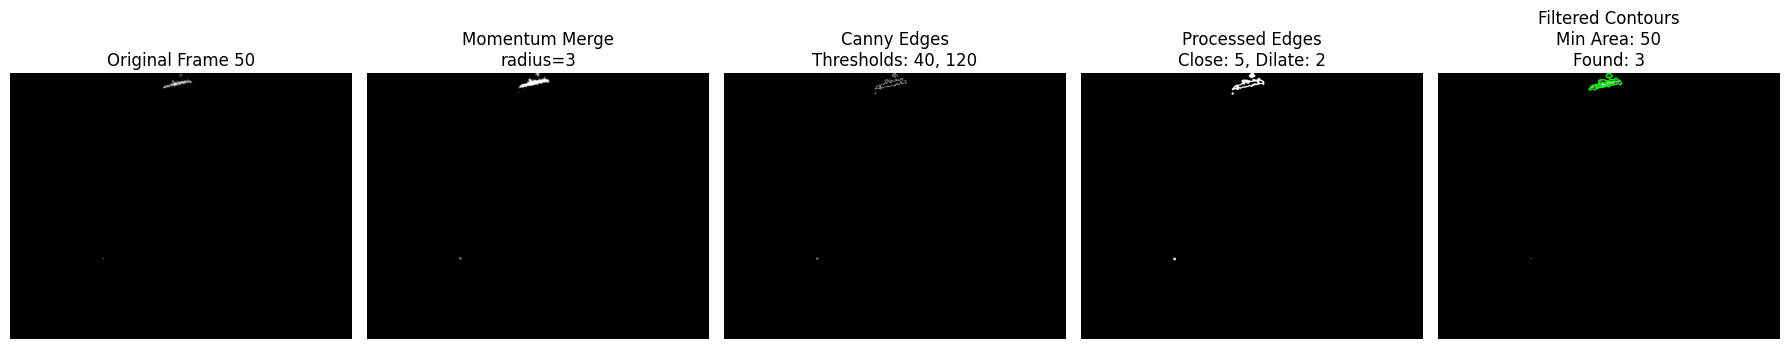


=== Current Processing Settings ===
Momentum merging: radius=3, threshold=0.2, decay=0.8
Canny thresholds: (40, 120)
Morphological closing kernel: 5
Edge dilation iterations: 2
Min contour area: 50
Total contours found: 7
Contours after area filter: 3
Improvement: 2 -> 3 contours after morphological processing

Reset min_contour_area back to 100


In [175]:
# Try a different frame or adjust settings
# Let's temporarily lower the min_area to see contours
temp_min_area = IMAGE_PROCESSING_CONFIG['min_contour_area']
IMAGE_PROCESSING_CONFIG['min_contour_area'] = 50  # Lower threshold temporarily

print("Trying with lower min_contour_area = 50...")
visualize_processing_steps(frame_index=50, npz_file_index=0)

# Reset to original value
IMAGE_PROCESSING_CONFIG['min_contour_area'] = temp_min_area
print(f"\nReset min_contour_area back to {temp_min_area}")

### Video Creation Results

The video shows:
- **Light blue**: All detected contours
- **Green**: Most elongated contour (thick line)
- **Red**: Bounding rectangle of selected contour
- **Magenta**: Fitted ellipse (when possible)
- **Text overlays**: Area, elongation score, contour count, frame number

You can adjust the parameters above:
- `frame_start`: Which frame to begin from
- `frame_count`: How many frames to process
- `frame_step`: Skip frames (1=every frame, 3=every 3rd frame)
- `npz_file_index`: Which NPZ file to use

Video info: 591 frames, 15.0 fps


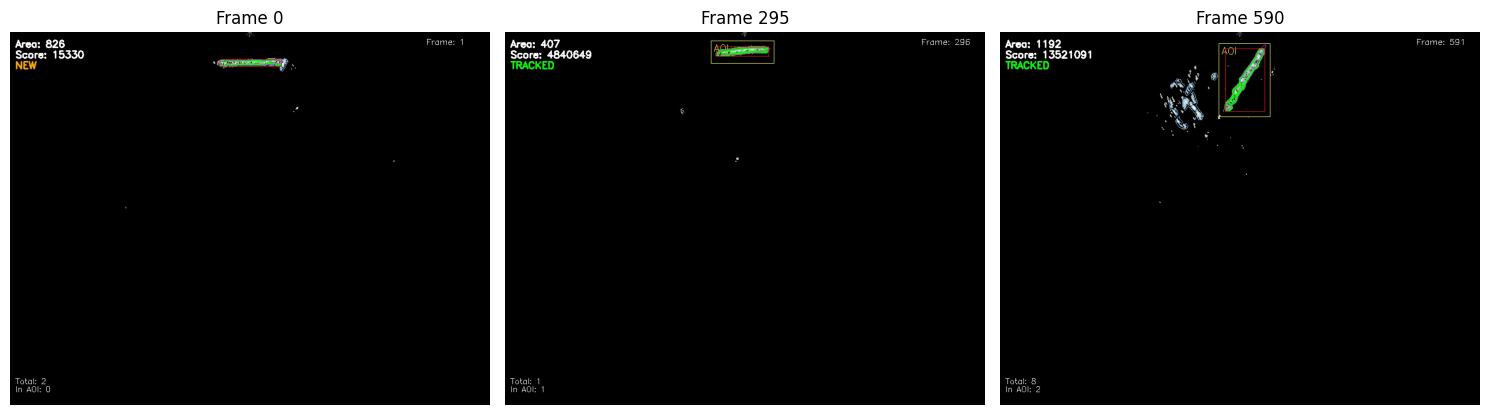

In [ ]:
# Optional: Preview a few frames from the video
def preview_video_frames(video_path, num_preview_frames=3):
    """
    Preview a few frames from the created video
    """
    if not os.path.exists(video_path):
        print(f"Video file not found: {video_path}")
        return
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video file")
        return
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Video info: {total_frames} frames, {fps:.1f} fps")
    
    # Calculate frame indices to preview
    frame_indices = [
        0,  # First frame
        total_frames // 2,  # Middle frame
        total_frames - 1   # Last frame
    ][:num_preview_frames]
    
    fig, axes = plt.subplots(1, len(frame_indices), figsize=(15, 5))
    if len(frame_indices) == 1:
        axes = [axes]
    
    for i, frame_idx in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            # Convert BGR to RGB for matplotlib
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(frame_rgb)
            axes[i].set_title(f'Frame {frame_idx}')
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'Failed to read frame', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Frame {frame_idx} (Error)')
    
    cap.release()
    plt.tight_layout()
    plt.show()

# Preview the created video
if video_path and os.path.exists(video_path):
    preview_video_frames(video_path, num_preview_frames=3)
else:
    print("Video not created yet. Run the cell above first.")